# DATA20001 Deep Learning - Group Project
## Image project

**Due Wednesday December 13, before 23:59.**

The task is to learn to assign the correct labels to a set of images.  The images are originally from a photo-sharing site and released under Creative Commons-licenses allowing sharing.  The training set contains 20 000 images. We have resized them and cropped them to 128x128 to make the task a bit more manageable.

We're only giving you the code for downloading the data. The rest you'll have to do yourselves.

Some comments and hints particular to the image project:

- One image may belong to many classes in this problem, i.e., it's a multi-label classification problem. In fact there are images that don't belong to any of our classes, and you should also be able to handle these correctly. Pay careful attention to how you design the outputs of the network (e.g., what activation to use) and what loss function should be used.

- As the dataset is pretty imbalanced, don't focus too strictly on the outputs being probabilistic. (Meaning that the right threshold for selecting the label might not be 0.5.)

- Image files can be loaded as numpy matrices for example using `imageio.imread`. Most images are color, but a few grayscale. You need to handle the grayscale ones somehow as they would have a different number of color channels (depth) than the color ones.

- Loading all the images into one big matrix as we have done in the exercises is not feasible (e.g. the virtual servers in CSC have only 3 GB of RAM). You need to load the images in smaller chunks for the training. This shouldn't be a problem we are doing mini-batch training anyway, and thus we don't need to keep all the images in memory. You can simply pass you current chunk of images to `model.fit()` as it remembers the weights from the previous run.

- You need to think carefully about how you load the annotations and match them up with the corresponding images, especially as you are loading them in smaller chunks.

## Download the data

In [1]:
from keras.utils.data_utils import get_file

database_path = 'train/'

dl_file='dl2017-image-proj.zip'
dl_url='https://www.cs.helsinki.fi/u/mvsjober/misc/'
get_file(dl_file, dl_url+dl_file, cache_dir='./', cache_subdir=database_path, extract=True)

Using TensorFlow backend.


278323200/279523357 [============================>.] - ETA: 0s

'./train/dl2017-image-proj.zip'

The above command downloaded and extracted the data files into the `train` subdirectory.

The images can be found in `train/images`, and are named as `im1.jpg`, `im2.jpg` and so on until `im20000.jpg`.

The class labels, or annotations, can be found in `train/annotations` as `CLASSNAME.txt`, where CLASSNAME is one of the fourteen classes: *baby, bird, car, clouds, dog, female, flower, male, night, people, portrait, river, sea,* and *tree*.

Each annotation file is a simple text file that lists the images that depict that class, one per line. The images are listed with their number, not the full filename. For example `5969` refers to the image `im5969.jpg`.

## Your stuff goes here ...

In [3]:
%matplotlib inline

import matplotlib.pylab as plt
import numpy as np
from scipy.misc import imread

image_count = 20000
image_dim = (128, 128, 3) # 128 x 128; RGB

num_classes = 14 + 1
UNCLASSIFIED_BIT = 14
labels = {
  0: 'baby',
  1: 'bird',
  2: 'car',
  3: 'clouds',
  4: 'dog',
  5: 'female',
  6: 'flower',
  7: 'male',
  8: 'night',
  9: 'people',
  10: 'portrait',
  11: 'river',
  12: 'sea',
  13: 'tree',
  UNCLASSIFIED_BIT: "unclassified"
}

labels_rev = {v: k for k, v in labels.items()}

# The labels are made into onehot vectors straight away
y = np.zeros((image_count, num_classes), dtype="uint8")

folder = "train/annotations/"
for num, label in labels.items():
    if num == UNCLASSIFIED_BIT:
        continue
    with open(folder + label +".txt", "r") as f:
        for line in f.readlines():
            # The indexing starts from 1 in dataset, but is converted to starting from 0
            y[int(line.strip())-1, num] = 1

for row in y:
    if sum(row) == 0:
        row[UNCLASSIFIED_BIT] = 1

In [4]:
# TODO create iterator class

def read_x(batch_size, begin_index, y):
    # normalizing range to be in 0.0 to 1.0
    normalize_values = True

    my_dtype = "uint8"
    if normalize_values:
        my_dtype = np.float32

    x_color = np.zeros((batch_size, *image_dim), dtype=my_dtype)
    end_index = begin_index + batch_size

    for i in range(begin_index, end_index):
        img = imread("train/images/im" + str(i+1) +".jpg")
        if normalize_values:
            img = img / 255
        if len(img.shape) == 3:
            x_color[i-begin_index] = img
        else:    
            x_color[i-begin_index] = np.repeat(img[:,:,np.newaxis], 3, axis=2) # B&W RGB representation

    return x_color, y[begin_index:end_index,:]      

In [5]:
x_testing, y_testing = read_x(2000, 2000, y)

In [6]:
x_testing.shape

(2000, 128, 128, 3)

In [7]:
from keras.models import Sequential
from keras.layers import *
from keras.optimizers import *
from keras.layers.convolutional import Conv2D
from keras.layers import BatchNormalization, Dropout

Using TensorFlow backend.


In [8]:
from keras import backend as K

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        
        return precision
    
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall))

In [10]:
# bp mll loss function
# y_true, y_pred must be 2D tensors of shape (batch dimension, number of labels)
# y_true must satisfy y_true[i][j] == 1 iff sample i has label j
def bp_mll_loss(y_true, y_pred):
 
    # get true and false labels
    y_i = K.equal(y_true, K.ones_like(y_true))
    y_i_bar = K.not_equal(y_true, K.ones_like(y_true))
    
    # cast to float as keras backend has no logical and
    y_i = K.cast(y_i, dtype='float32')
    y_i_bar = K.cast(y_i_bar, dtype='float32')

    # get indices to check
    truth_matrix = pairwise_and(y_i, y_i_bar)

    # calculate all exp'd differences
    sub_matrix = pairwise_sub(y_pred, y_pred)
    exp_matrix = K.exp(-sub_matrix)

    # check which differences to consider and sum them
    sparse_matrix = exp_matrix * truth_matrix
    sums = K.sum(sparse_matrix, axis=[1,2])

    # get normalizing terms and apply them
    y_i_sizes = K.sum(y_i, axis=1)
    y_i_bar_sizes = K.sum(y_i_bar, axis=1)
    normalizers = y_i_sizes * y_i_bar_sizes
    results = sums / normalizers

    # sum over samples
    return K.sum(results)

# compute pairwise differences between elements of the tensors a and b
def pairwise_sub(a, b):
    column = K.expand_dims(a, 2)
    row = K.expand_dims(b, 1)
    return column - row

# compute pairwise logical and between elements of the tensors a and b
def pairwise_and(a, b):
    column = K.expand_dims(a, 2)
    row = K.expand_dims(b, 1)
    return K.minimum(column, row)

In [11]:
# Callback to get micro-averaged F1 score after each epoch
import keras
from sklearn.metrics import f1_score

class MetricsHistory(keras.callbacks.Callback):
    def __init__(self, x_test, y_test, threshold=0.5):
        self.x_test = x_test
        self.y_test = y_test
        self.threshold = threshold
        
        self.epochs = 0
        self.train_loss = []
        self.train_bin_acc = []
        self.test_loss = []
        self.test_bin_acc = []
        self.test_f1_score_15 = []
        self.test_f1_score_14 = []
    
    def on_epoch_end(self, epoch, logs={}):
        
        self.epochs += 1
        self.train_loss.append(logs.get('loss'))
        self.train_bin_acc.append(logs.get('binary_accuracy'))
        
        pred = model.predict(self.x_test)
        pred[np.where(pred > self.threshold)] = 1
        pred[np.where(pred <= self.threshold)] = 0
        y_pred = pred.astype(np.bool)
        
        self.test_f1_score_15.append(f1_score(y_test, y_pred, average='micro'))
        self.test_f1_score_14.append(f1_score(y_test[:,:-1], y_pred[:,:-1], average='micro'))
        
        scores = model.evaluate(x_test, y_test, verbose=2)
        self.test_loss.append(scores[0])
        self.test_bin_acc.append(scores[1])
        
    

In [40]:
model = Sequential()

# Add layers here

model.add(Conv2D(32, (3, 3), input_shape=(128, 128, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(num_classes))
model.add(Activation("sigmoid"))


# binary_crossentropy
model.compile(loss=bp_mll_loss, 
              optimizer='rmsprop', 
              metrics=['binary_accuracy', "categorical_accuracy", f1])

test_f1_score_15 = []
test_f1_score_14 = []
train_loss = []
test_loss = []
train_bin_acc = []
test_bin_acc = []

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 126, 126, 32)      896       
_________________________________________________________________
activation_15 (Activation)   (None, 126, 126, 32)      0         
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 61, 61, 32)        9248      
_________________________________________________________________
activation_16 (Activation)   (None, 61, 61, 32)        0         
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 28, 28, 64)        18496     
__________

In [24]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
                #rescale=1./255,
                shear_range=0.2,
                zoom_range=0.2,
                horizontal_flip=True,
                vertical_flip=True)

In [26]:
%%time
from sklearn.model_selection import train_test_split

batch_size = 2000

iterations = [0,2000,4000]


for i in range(len(iterations)):
    x_some, y_some = read_x(batch_size, iterations[i], y)
    
    # combine all val created here into final test set?
    x_train, x_val, y_train, y_val = train_test_split(x_some, y_some, test_size=0.2, random_state=142)
    epochs = 2

    history = model.fit_generator(train_datagen.flow(x_train, y_train, batch_size=32),
                                    steps_per_epoch=len(x_train) / 32, 
                                    epochs=epochs,
                                    validation_data=(x_val, y_val))
    

Epoch 1/2
50/50 [==============================] - 21s - loss: 24.3232 - binary_accuracy: 0.7140 - categorical_accuracy: 0.3287 - f1: 0.3335 - val_loss: 22.0138 - val_binary_accuracy: 0.7783 - val_categorical_accuracy: 0.4625 - val_f1: 0.3911
Epoch 2/2
50/50 [==============================] - 19s - loss: 23.7008 - binary_accuracy: 0.7470 - categorical_accuracy: 0.3687 - f1: 0.3523 - val_loss: 21.8509 - val_binary_accuracy: 0.8247 - val_categorical_accuracy: 0.4625 - val_f1: 0.4106
Epoch 1/2
50/50 [==============================] - 19s - loss: 22.1720 - binary_accuracy: 0.7948 - categorical_accuracy: 0.4250 - f1: 0.4079 - val_loss: 22.7432 - val_binary_accuracy: 0.8270 - val_categorical_accuracy: 0.4475 - val_f1: 0.4190
Epoch 2/2
50/50 [==============================] - 19s - loss: 21.9049 - binary_accuracy: 0.8117 - categorical_accuracy: 0.4438 - f1: 0.4291 - val_loss: 22.5230 - val_binary_accuracy: 0.8452 - val_categorical_accuracy: 0.4275 - val_f1: 0.4403
Epoch 1/2
50/50 [===========

In [28]:
threshold = 0.5

pred = model.predict(x_test)
pred[np.where(pred > threshold)] = 1
pred[np.where(pred <= threshold)] = 0
y_pred = pred.astype(np.bool)
#y_pred = y_pred[:, :num_classes-1]

In [29]:
from sklearn.metrics import f1_score
y_true = y_test

print(f1_score(y_true, y_pred, average='micro'))
print(f1_score(y_true[:, :num_classes-1], y_pred[:, :num_classes-1], average='micro'))

0.432692307692
0.334633994069


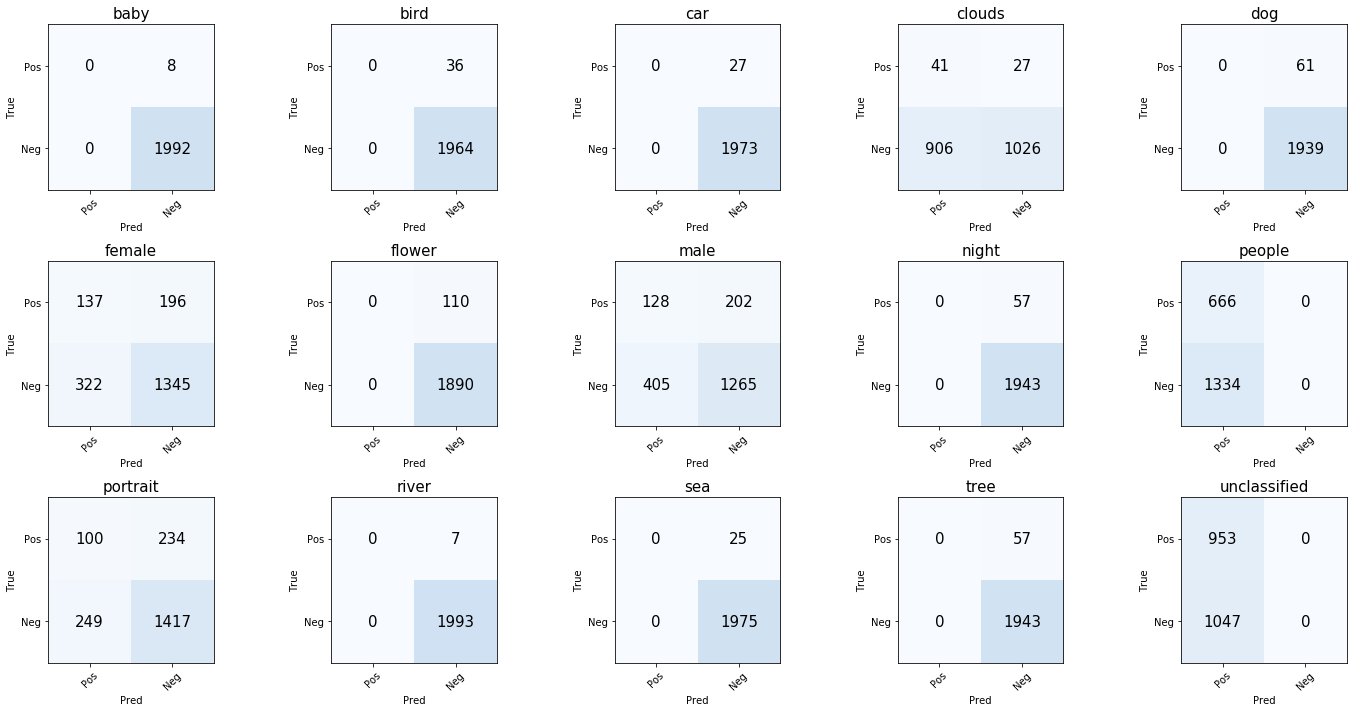

In [41]:
# Confusion matrices per label
from sklearn.metrics import confusion_matrix
"""
# Old way of calculating
true_pos = np.sum(y_test * y_pred, axis=0)
pred_pos = np.sum(y_pred, axis = 0)
false_pos = pred_pos - true_pos

true_neg = np.sum(y_test == y_pred, axis=0) - true_pos 
pred_neg = np.sum(y_pred == 0, axis = 0)
false_neg = pred_neg - true_neg
"""



plt.figure(figsize=(20, 10))

for i in range(len(true_pos)):
    
    plt.subplot(3, 5, i+1)
    
    true_neg, false_pos, false_neg, true_pos = confusion_matrix(y_test[:,i], y_pred[:,i]).ravel()
    
    matrix = np.zeros((2,2), dtype="uint32")
    matrix[0,0] = true_pos
    matrix[0,1] = false_neg
    matrix[1,1] = true_neg
    # sanity check: bottom left, predicted pos, true was neg
    matrix[1,0] = false_pos

    plt.imshow(matrix, 
               cmap=plt.cm.Blues, 
               interpolation='nearest',
               vmin=0, vmax=10000)

    for x in range(2):
        for y in range(2):
            plt.text(y, x, str(matrix[x,y]),
                        fontsize=15,
                        horizontalalignment='center',
                        verticalalignment='center')

    classes = ["Pos", "Neg"]
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.ylabel('True')
    plt.xlabel('Pred')
    plt.title(labels[i], fontsize=15)
    

plt.tight_layout()
plt.show()

In [33]:
from sklearn.metrics import confusion_matrix

for i in range(y_train.shape[1]):
    print("Col {}".format(i))
    tn, fp, fn, tp = confusion_matrix(y_test[:,i], y_pred[:,i]).ravel()
    y_train.shape[1]
    print("Label {}".format(labels[i]))
    print("True-Neg:", tn)
    print("False-Neg:", fn)
    print("True-Pos:", tp)
    print("False-Pos:", fp)
    print("")

Col 0
Label baby
True-Neg: 1992
False-Neg: 8
True-Pos: 0
False-Pos: 0

Col 1
Label bird
True-Neg: 1964
False-Neg: 36
True-Pos: 0
False-Pos: 0

Col 2
Label car
True-Neg: 1973
False-Neg: 27
True-Pos: 0
False-Pos: 0

Col 3
Label clouds
True-Neg: 1026
False-Neg: 27
True-Pos: 41
False-Pos: 906

Col 4
Label dog
True-Neg: 1939
False-Neg: 61
True-Pos: 0
False-Pos: 0

Col 5
Label female
True-Neg: 1345
False-Neg: 196
True-Pos: 137
False-Pos: 322

Col 6
Label flower
True-Neg: 1890
False-Neg: 110
True-Pos: 0
False-Pos: 0

Col 7
Label male
True-Neg: 1265
False-Neg: 202
True-Pos: 128
False-Pos: 405

Col 8
Label night
True-Neg: 1943
False-Neg: 57
True-Pos: 0
False-Pos: 0

Col 9
Label people
True-Neg: 0
False-Neg: 0
True-Pos: 666
False-Pos: 1334

Col 10
Label portrait
True-Neg: 1417
False-Neg: 234
True-Pos: 100
False-Pos: 249

Col 11
Label river
True-Neg: 1993
False-Neg: 7
True-Pos: 0
False-Pos: 0

Col 12
Label sea
True-Neg: 1975
False-Neg: 25
True-Pos: 0
False-Pos: 0

Col 13
Label tree
True-Neg: 1943

## Save your model

It might be useful to save your model if you want to continue your work later, or use it for inference later.

In [135]:
model.save('model.h5')

The model file should now be visible in the "Home" screen of the jupyter notebooks interface.  There you should be able to select it and press "download".

## Predict for test set

You will be asked to return your prediction for the testset.  These should be returned as a matrix with one row for each test set image.  Each row contains a binary prediction for each label, 1 if it's present in the image, and 0 if not. The order of the labels is as follows (alphabetic order of the label names):

    baby bird car clouds dog female flower male night people portrait river sea tree

An example row could like like this if your system predicts the presense of a bird and clouds:

    0 1 0 1 0 0 0 0 0 0 0 0 0 0
    
If you have the matrix prepared in `y` (e.g., by calling `y=model.predict(x_test)`) you can use the following function to save it to a text file.

In [ ]:
np.savetxt('results.txt', y, fmt='%d')